### Load the required modules, classes

In [220]:
from models import Net, UltimusBlock

In [239]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder

import matplotlib.pyplot as plt
%matplotlib inline

In [222]:
import torchvision
import torchvision.transforms as transforms

### Download the datasets

In [223]:
batch_size=256

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [224]:
cuda = torch.cuda.is_available()

device = 'cpu'

if cuda:
    device = 'cuda'
    
    
print(device)

cuda


### Define the Model, optimizer and criterion

In [225]:
nn_model = MyNet(8).to(device)
summary(nn_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2           [-1, 32, 32, 32]           4,640
            Conv2d-3           [-1, 48, 32, 32]          13,872
         AvgPool2d-4             [-1, 48, 1, 1]               0
            Linear-5                    [-1, 8]             392
            Linear-6                    [-1, 8]             392
            Linear-7                    [-1, 8]             392
            Linear-8                   [-1, 48]             432
      UltimusBlock-9                   [-1, 48]               0
           Linear-10                    [-1, 8]             392
           Linear-11                    [-1, 8]             392
           Linear-12                    [-1, 8]             392
           Linear-13                   [-1, 48]             432
     UltimusBlock-14                   

In [226]:
nn_model = MyNet(8).to(device)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

### Use the LRFinder to get the optimum learning_rate for the optimizer

In [227]:
lr_finder = LRFinder(nn_model, optimizer, criterion, device='cuda')

In [228]:
lr_finder.range_test(trainloader, end_lr=0.01, num_iter=500, step_mode='exp')

  0%|          | 0/500 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.07E-03


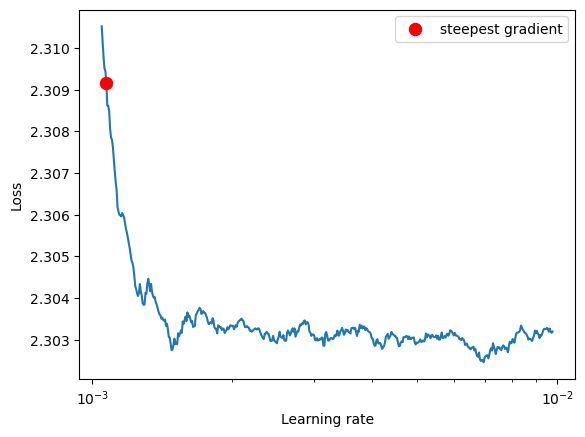

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.0010716676480328636)

In [229]:
lr_finder.plot()

In [230]:
lr_finder.reset()

### Update the max_lr and other parameters of the "OneCycleLR" scheduler

In [231]:
max_lr = 1.07E-03
base_lr = max_lr/10
epochs = 24

In [232]:
scheduler = OneCycleLR(optimizer, 
                      max_lr = max_lr,
                      epochs=epochs,
                      steps_per_epoch=len(trainloader),
                      anneal_strategy='linear',
                      div_factor=40)

### Define the epochs, train and test function

In [233]:
# Define the number of epochs to train for
num_epochs = 24
epoch_train_losses = []
epoch_train_accs = []

epoch_test_losses = []
epoch_test_accs = []


# Train function
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    train_losses = []
    train_accs = []
    
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Compute training accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Compute and store training loss and accuracy
        train_losses.append(loss.item())
        train_accs.append(100. * correct / total)

    # Print and store training loss and accuracy
    epoch_train_loss = sum(train_losses[-len(trainloader):]) / len(trainloader)
    epoch_train_acc = sum(train_accs[-len(trainloader):]) / len(trainloader)
    
    epoch_train_losses.append(epoch_train_loss)
    epoch_train_accs.append(epoch_train_acc)
    
    print(f"training loss: {epoch_train_loss:.4f}, accuracy: {epoch_train_acc:.2f}, Optimzer LR: {optimizer.param_groups[0]['lr']}")

    return train_losses, train_accs

# Test function
def test(model, testloader, criterion, device):
    model.eval()
    test_losses = []
    test_accs = []
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Compute test accuracy
            _, predicted = outputs.max(1)
            total = targets.size(0)
            correct = predicted.eq(targets).sum().item()

            # Compute and store test loss and accuracy
            test_losses.append(loss.item())
            test_accs.append(100. * correct / total)

        # Print and store test loss and accuracy
        test_loss = sum(test_losses) / len(testloader)
        test_acc = sum(test_accs) / len(testloader)
        
        epoch_test_losses.append(test_loss)
        epoch_test_accs.append(test_acc)
        print(f"Test loss: {test_loss:.4f}, accuracy: {test_acc:.2f}")

    return test_losses, test_accs


In [234]:
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    train(nn_model, trainloader, optimizer, criterion, device)
    test(nn_model, testloader, criterion, device)

Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 24.15it/s]


training loss: 2.3053, accuracy: 10.00, Optimzer LR: 0.00017174858176145227


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.00it/s]


Test loss: 2.3034, accuracy: 9.77
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 24.48it/s]


training loss: 2.3029, accuracy: 10.16, Optimzer LR: 0.00031674716352290456


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.27it/s]


Test loss: 2.3026, accuracy: 10.21
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:07<00:00, 24.60it/s]


training loss: 2.3028, accuracy: 9.60, Optimzer LR: 0.00046174574528435675


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.08it/s]


Test loss: 2.3026, accuracy: 10.21
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:07<00:00, 24.69it/s]


training loss: 2.3028, accuracy: 10.07, Optimzer LR: 0.000606744327045809


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.74it/s]


Test loss: 2.3028, accuracy: 9.77
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:07<00:00, 24.65it/s]


training loss: 2.3028, accuracy: 9.71, Optimzer LR: 0.0007517429088072613


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.56it/s]


Test loss: 2.3027, accuracy: 10.21
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 24.50it/s]


training loss: 2.3028, accuracy: 9.88, Optimzer LR: 0.0008967414905687135


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.10it/s]


Test loss: 2.3027, accuracy: 10.21
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 24.12it/s]


training loss: 2.3028, accuracy: 9.85, Optimzer LR: 0.001041740072330166


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.65it/s]


Test loss: 2.3026, accuracy: 10.21
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:07<00:00, 24.81it/s]


training loss: 2.3027, accuracy: 9.95, Optimzer LR: 0.0010187227958318148


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.81it/s]


Test loss: 2.3026, accuracy: 9.77
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 23.99it/s]


training loss: 2.3027, accuracy: 9.86, Optimzer LR: 0.0009550324788675292


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.97it/s]


Test loss: 2.3026, accuracy: 10.21
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:07<00:00, 24.65it/s]


training loss: 2.3027, accuracy: 9.73, Optimzer LR: 0.0008913421619032435


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.98it/s]


Test loss: 2.3026, accuracy: 10.21
Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:07<00:00, 24.63it/s]


training loss: 2.3027, accuracy: 9.79, Optimzer LR: 0.0008276518449389578


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.03it/s]


Test loss: 2.3026, accuracy: 10.21
Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 23.52it/s]


training loss: 2.3026, accuracy: 9.68, Optimzer LR: 0.000763961527974672


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.06it/s]


Test loss: 2.3026, accuracy: 10.21
Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 24.27it/s]


training loss: 2.3026, accuracy: 10.06, Optimzer LR: 0.0007002712110103864


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.62it/s]


Test loss: 2.3026, accuracy: 9.91
Epoch: 14


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 24.08it/s]


training loss: 2.3026, accuracy: 9.65, Optimzer LR: 0.0006365808940461006


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.24it/s]


Test loss: 2.3026, accuracy: 9.77
Epoch: 15


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:07<00:00, 24.78it/s]


training loss: 2.3026, accuracy: 9.39, Optimzer LR: 0.0005728905770818149


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 13.37it/s]


Test loss: 2.3026, accuracy: 9.77
Epoch: 16


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 24.47it/s]


training loss: 2.3026, accuracy: 9.85, Optimzer LR: 0.0005092002601175292


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.06it/s]


Test loss: 2.3026, accuracy: 9.77
Epoch: 17


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 24.49it/s]


training loss: 2.3026, accuracy: 9.59, Optimzer LR: 0.0004455099431532435


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.98it/s]


Test loss: 2.3026, accuracy: 9.77
Epoch: 18


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 23.40it/s]


training loss: 2.3026, accuracy: 9.83, Optimzer LR: 0.0003818196261889576


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.10it/s]


Test loss: 2.3026, accuracy: 9.77
Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:07<00:00, 24.60it/s]


training loss: 2.3026, accuracy: 10.17, Optimzer LR: 0.0003181293092246719


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.08it/s]


Test loss: 2.3026, accuracy: 9.77
Epoch: 20


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:07<00:00, 24.72it/s]


training loss: 2.3026, accuracy: 9.86, Optimzer LR: 0.00025443899226038633


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.18it/s]


Test loss: 2.3026, accuracy: 9.77
Epoch: 21


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:07<00:00, 24.64it/s]


training loss: 2.3026, accuracy: 9.74, Optimzer LR: 0.00019074867529610053


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.07it/s]


Test loss: 2.3026, accuracy: 10.06
Epoch: 22


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:07<00:00, 24.51it/s]


training loss: 2.3026, accuracy: 10.12, Optimzer LR: 0.00012705835833181484


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.72it/s]


Test loss: 2.3026, accuracy: 10.21
Epoch: 23


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 23.83it/s]


training loss: 2.3026, accuracy: 10.11, Optimzer LR: 6.336804136752904e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.70it/s]


Test loss: 2.3026, accuracy: 10.21
Epoch: 24


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:08<00:00, 24.06it/s]


training loss: 2.3026, accuracy: 9.72, Optimzer LR: -3.2227559675643627e-07


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.74it/s]

Test loss: 2.3026, accuracy: 10.21


### Plotting

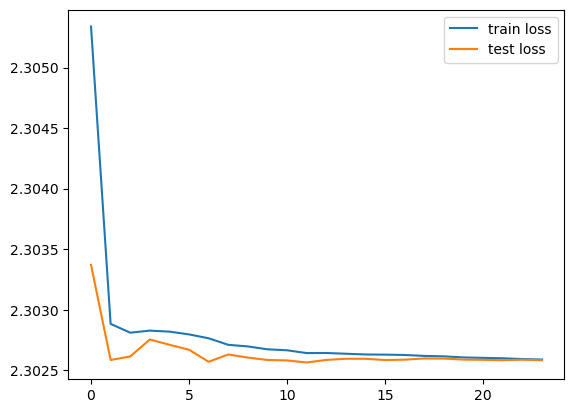

In [241]:
# plotting

x_range = list(range(24))

plt.plot(x_range, epoch_train_losses, label='train loss')
plt.plot(x_range, epoch_test_losses, label='test loss')
plt.legend()

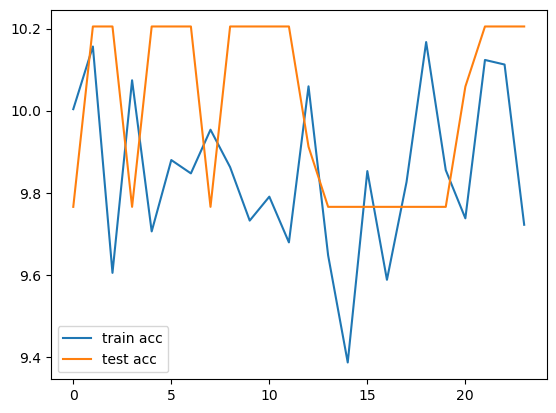

In [242]:
plt.plot(x_range, epoch_train_accs, label='train acc')
plt.plot(x_range, epoch_test_accs, label='test acc')
plt.legend()